## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [74]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='brute', weights="uniform", metric="euclidean"):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.weights = weights
        self.scaler = StandardScaler()
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X_train = np.array(X)
            
            if self.metric == 'euclidean':
                self.X_train = self.scaler.fit_transform(self.X_train)
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X)        
        self.y = np.array(y)
        
    def predict(self, X):
        self.X_test = X
        if self.algorithm == 'brute':
            if self.metric == 'euclidean':
                self.X_test = self.scaler.transform(X)
            
            pwdist = pairwise_distances(self.X_test, self.X_train, metric=self.metric)
            indices_neighbors = self.k_neighborse(pwdist)
        elif self.algorithm == "kd_tree":
            pwdist, indices_neighbors = self.tree.query(self.X_test, k=self.n_neighbors)
        return self.y[np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, indices_neighbors)]
    
    def k_neighborse(self, neighbors):
        return np.argsort(neighbors, axis=1)[:, :self.n_neighbors]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [99]:
iris = datasets.load_iris()

In [100]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [101]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [102]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [103]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)

In [104]:
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [105]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.22 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [106]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.11 ms


In [107]:
%time clf.predict(X_test)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 4.76 ms


array([1, 0, 2, 1, 0, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0])

In [108]:
%time my_clf.predict(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.86 ms


array([1, 0, 2, 1, 0, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [109]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [110]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [111]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.85 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [112]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 214 µs


In [113]:
%time clf.predict(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.6 ms


array([1, 0, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1])

In [114]:
%time my_clf.predict(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 946 µs


array([1, 0, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1])

In [115]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [28]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [29]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [5]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)
X = np.array(X.toarray())

In [42]:
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = np.array(vectorizer_tfidf.fit_transform(data).toarray())

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [24]:
n_fold = 3
kf = KFold(n_splits=n_fold)
kf

KFold(n_splits=3, random_state=None, shuffle=False)

In [34]:
def plot_clf(results, array, color):    
    fig, ax = plt.subplots()
    ax.plot(array, results, color = color)

    ax.set(xlabel ='n_neighbors', ylabel ='score', ylim =(0, 1))
    ax.grid()

    plt.show()

In [26]:
def k_neighborse(X, target, metrics=["euclidean", "cosine"], classifier=MyKNeighborsClassifier):
    scores = []
    for train_index, test_index in kf.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = target[train_index], target[test_index]
        metric_score = []
        for metric in metrics:
            score = []
            
            for i in range(1, 11):
                clf = classifier(n_neighbors=i, algorithm='brute', metric=metric)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                result = accuracy_score(y_test, y_pred)
                score.append(result)
                print(f"i = {i}, metric = {metric}, score = {result}")
                
            metric_score.append(score)
        scores.append(metric_score)
    return scores

In [27]:
scores = k_neighborse(X, target)

TRAIN: [ 3772  3773  3774 ... 11311 11312 11313] TEST: [   0    1    2 ... 3769 3770 3771]
i = 1, metric = euclidean, score = 0.2576882290562036
i = 2, metric = euclidean, score = 0.20625662778366913
i = 3, metric = euclidean, score = 0.1651643690349947
i = 4, metric = euclidean, score = 0.14422057264050903
i = 5, metric = euclidean, score = 0.1283138918345705
i = 6, metric = euclidean, score = 0.11240721102863202
i = 7, metric = euclidean, score = 0.10047720042417815
i = 8, metric = euclidean, score = 0.09278897136797455
i = 9, metric = euclidean, score = 0.08854718981972429
i = 10, metric = euclidean, score = 0.0861611876988335
i = 1, metric = cosine, score = 0.2953340402969247
i = 2, metric = cosine, score = 0.24284199363732767
i = 3, metric = cosine, score = 0.2192470837751856
i = 4, metric = cosine, score = 0.20519618239660659
i = 5, metric = cosine, score = 0.19034994697773064
i = 6, metric = cosine, score = 0.18160127253446448
i = 7, metric = cosine, score = 0.17444326617179215


In [13]:
scores_arr = np.array(scores)
scores_arr

array([[[0.25768823, 0.20625663, 0.16516437, 0.14422057, 0.12831389,
         0.11240721, 0.1004772 , 0.09278897, 0.08854719, 0.08616119],
        [0.29533404, 0.24284199, 0.21924708, 0.20519618, 0.19034995,
         0.18160127, 0.17444327, 0.16887593, 0.16277837, 0.15641569]],

       [[0.2543092 , 0.20392469, 0.16971626, 0.14691063, 0.12622647,
         0.11667993, 0.10872448, 0.09944312, 0.09334394, 0.09334394],
        [0.28692654, 0.24767966, 0.21585786, 0.20021215, 0.19040042,
         0.18456643, 0.17793689, 0.16918589, 0.16653408, 0.16520817]],

       [[0.25404402, 0.19994696, 0.16441262, 0.13869   , 0.12490056,
         0.11455847, 0.10474675, 0.09891276, 0.09360912, 0.09228321],
        [0.29488199, 0.24317157, 0.22434368, 0.20604614, 0.20127287,
         0.19464333, 0.18668788, 0.18032352, 0.17581543, 0.16945107]]])

In [17]:
adv_scores_euclidean = scores_arr[:, 0, :].mean(axis=0)
adv_scores_cosine = scores_arr[:, 1, :].mean(axis=0)

In [18]:
adv_scores_euclidean

array([0.25534715, 0.20337609, 0.16643108, 0.14327373, 0.12648031,
       0.11454854, 0.10464948, 0.09704828, 0.09183342, 0.09059611])

In [48]:
scores_tfidf = k_neighborse(X_tfidf, target)

TRAIN: [ 3772  3773  3774 ... 11311 11312 11313] TEST: [   0    1    2 ... 3769 3770 3771]
i = 1, metric = euclidean, score = 0.13626723223753975
i = 2, metric = euclidean, score = 0.09437963944856839
i = 3, metric = euclidean, score = 0.08669141039236479
i = 4, metric = euclidean, score = 0.07900318133616119
i = 5, metric = euclidean, score = 0.07025450689289502
i = 6, metric = euclidean, score = 0.06203605514316013
i = 7, metric = euclidean, score = 0.06521739130434782
i = 8, metric = euclidean, score = 0.06707317073170732
i = 9, metric = euclidean, score = 0.06389183457051961
i = 10, metric = euclidean, score = 0.06495227995758218
i = 1, metric = cosine, score = 0.588016967126193
i = 2, metric = cosine, score = 0.545864262990456
i = 3, metric = cosine, score = 0.5206786850477201
i = 4, metric = cosine, score = 0.4960233297985154
i = 5, metric = cosine, score = 0.4777306468716861
i = 6, metric = cosine, score = 0.4695121951219512
i = 7, metric = cosine, score = 0.454135737009544
i = 

In [14]:
scores_tfidf

array([[[0.13626723, 0.09437964, 0.08669141, 0.07900318, 0.07025451,
         0.06203606, 0.06521739, 0.06707317, 0.06389183, 0.06495228],
        [0.58801697, 0.54586426, 0.52067869, 0.49602333, 0.47773065,
         0.4695122 , 0.45413574, 0.44644751, 0.43637328, 0.42364793]],

       [[0.15725272, 0.10342084, 0.08406258, 0.08353222, 0.07345532,
         0.07133386, 0.06470432, 0.06417396, 0.06284805, 0.06284805],
        [0.59268099, 0.53990984, 0.48952532, 0.47175815, 0.45584726,
         0.43648899, 0.42561655, 0.4176611 , 0.40519756, 0.39856802]],

       [[0.14531954, 0.09360912, 0.07769822, 0.06735614, 0.06682578,
         0.06152214, 0.05940069, 0.05833996, 0.0578096 , 0.06178732],
        [0.6070008 , 0.55263856, 0.51073986, 0.4826306 , 0.4566428 ,
         0.43648899, 0.41951737, 0.40652347, 0.39750729, 0.39061257]]])

In [6]:
scores_tfidf = np.array(scores_tfidf)
adv_scores_euclidean_tfidf = scores_tfidf[:, 0, :].mean(axis=0)
adv_scores_cosine_tfidf = scores_tfidf[:, 1, :].mean(axis=0)

In [7]:
adv_scores_euclidean_tfidf

array([0.14627983, 0.09713653, 0.08281741, 0.07663051, 0.07017853,
       0.06496402, 0.06310747, 0.0631957 , 0.0615165 , 0.06319589])

In [8]:
adv_scores_cosine_tfidf

array([0.59589958, 0.54613755, 0.50698129, 0.4834707 , 0.4634069 ,
       0.44749673, 0.43308988, 0.42354402, 0.41302604, 0.40427617])

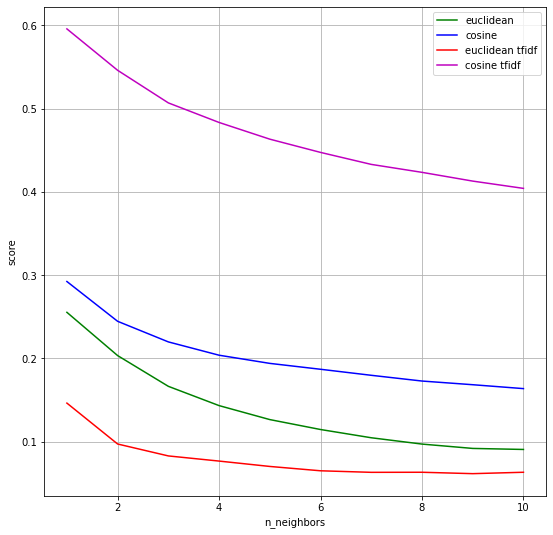

In [19]:
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(list(range(1, 11)), adv_scores_euclidean, color = 'g', label='euclidean')
ax.plot(list(range(1, 11)), adv_scores_cosine, color = 'b', label='cosine')
ax.plot(list(range(1, 11)), adv_scores_euclidean_tfidf, color = 'r', label='euclidean tfidf')
ax.plot(list(range(1, 11)), adv_scores_cosine_tfidf, color = 'm', label='cosine tfidf')

ax.set(xlabel ='n_neighbors', ylabel ='score')
ax.grid(True)
ax.legend()
plt.show()

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [36]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [37]:
data_test = newsgroups_test['data']
target_test = newsgroups_test['target']

In [22]:
newsgroups_X = vectorizer.transform(data_test)
newsgroups_X = np.array(newsgroups_X.toarray())

In [43]:
newsgroups_X_tfidf = np.array(vectorizer_tfidf.transform(data_test).toarray())

In [72]:
score = []
for i in range(1, 11):
    clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='brute', metric="cosine")
    clf.fit(X_tfidf, target)
    y_pred = clf.predict(newsgroups_X_tfidf)
    result = accuracy_score(target_test, y_pred)
    score.append(result)

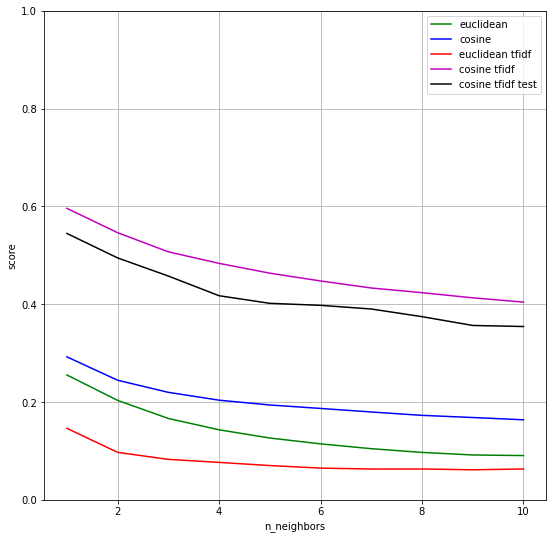

In [70]:
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(list(range(1, 11)), adv_scores_euclidean, color = 'g', label='euclidean')
ax.plot(list(range(1, 11)), adv_scores_cosine, color = 'b', label='cosine')
ax.plot(list(range(1, 11)), adv_scores_euclidean_tfidf, color = 'r', label='euclidean tfidf')
ax.plot(list(range(1, 11)), adv_scores_cosine_tfidf, color = 'm', label='cosine tfidf')
ax.plot(list(range(1, 11)), score, color = 'k', label='cosine tfidf test')

ax.set(xlabel ='n_neighbors', ylabel ='score', ylim =(0, 1))
ax.grid(True)
ax.legend()
plt.show()